In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utils import video2st_maps as v2m
import config
import cv2

Pipeline

0. Get HR as correct signal from pyVHR
1. Extract spatial temporal map
2. Train
3. Eval
4. Predict

In [2]:
video_path = '../data/test/cpi_rotation.mp4'
cap = cv2.VideoCapture(video_path)
cap.get(5)

25.0

In [10]:
meta = v2m.get_frames_and_video_meta_data(video_path,True)
meta

{'frame_rate': 25.0, 'sliding_window_stride': 12, 'num_frames': 2020}

In [ ]:
v2m.get_spatio_temporal_map_threaded(video_path)

In [2]:
st_map = np.load('../data/st_maps/test/cpi_rotation.npy')

In [3]:
map_shape = st_map.shape
maps = st_map.reshape((-1, map_shape[3], map_shape[1], map_shape[2]))
maps.shape

(144, 3, 300, 25)

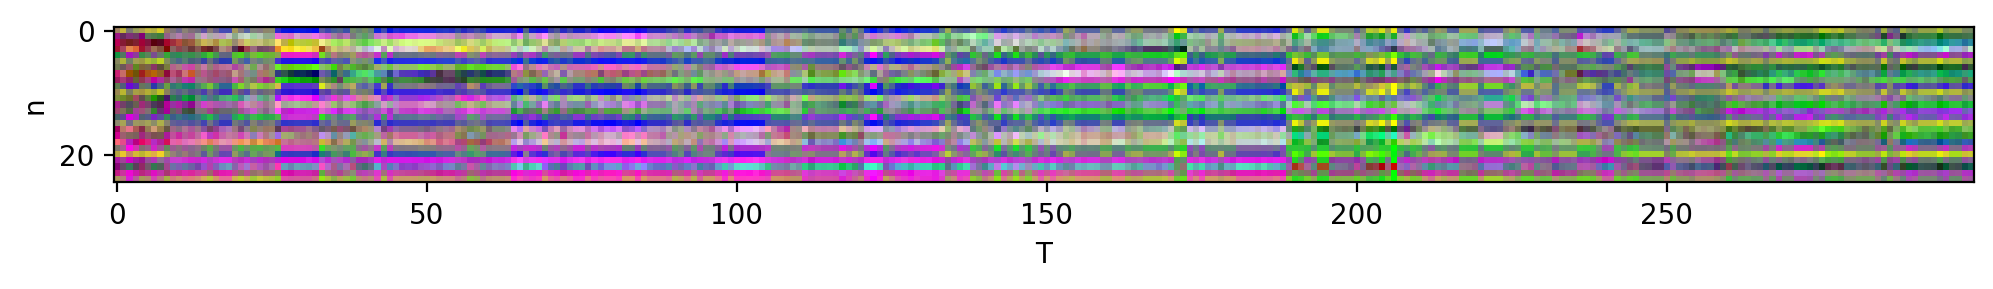

In [4]:
fig, ax = plt.subplots(figsize=(12,12),dpi=200)
ax.imshow(np.transpose(st_map[0,:,:,:].astype(np.uint8),(1,0,2)));
ax.set_xlabel('T')
ax.set_ylabel('n')
plt.savefig('spm.png')

In [9]:
st_map_torch = next(iter(test_loader))

In [10]:
# batch x n_maps x n_channels x T (clip size) x n (#face regions)
st_map_torch[0]['st_maps'].size()

torch.Size([83, 3, 300, 25])

In [11]:
a = st_map_torch[0]['st_maps'].numpy()
b = a.reshape((-1, a.shape[3], a.shape[1], a.shape[2]))
b.shape

(83, 25, 3, 300)

In [12]:
st_map_torch[0]['st_maps'][0,:,:,:].numpy().astype(np.uint8).shape

(3, 300, 25)

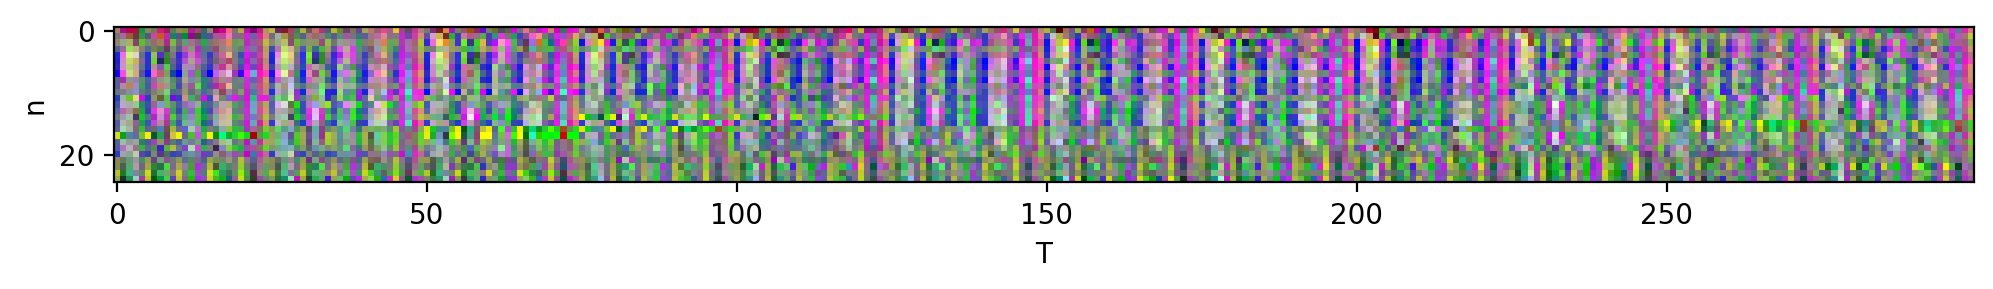

In [14]:
fig, ax = plt.subplots(figsize=(12,12),dpi=200)
ax.imshow(np.reshape(st_map_torch[0]['st_maps'][0,:,:,:].numpy().astype(np.uint8),(25,300,3)));
ax.set_xlabel('T')
ax.set_ylabel('n')
plt.savefig('spm.png')

In [ ]:
# for i in range(st_map.shape[0]):
#     fig, ax = plt.subplots(figsize=(12,12),dpi=200)
#     ax.imshow(np.transpose(st_map[i,:,:,:].astype(np.uint8),(1,0,2)));
#     ax.set_xlabel('T')
#     ax.set_ylabel('n')
#     plt.savefig(f'spms/spm{i}.png')
#     plt.close(fig)

In [5]:
import os
from utils.dataset import DataLoaderRhythmNet
from utils.model_utils import plot_loss, load_model_if_checkpointed, save_model_checkpoint
from models.rhythmNet import RhythmNet
from loss_func.rhythmnet_loss import RhythmNetLoss
import torch
import config
from torch.utils.tensorboard import SummaryWriter

import utils.train_val as train_val
from utils.plot_scripts import plot_train_test_curves, bland_altman_plot, gt_vs_est, create_plot_for_tensorboard

In [6]:
# check path to checkpoint directory
if config.CHECKPOINT_PATH:
    if not os.path.exists(config.CHECKPOINT_PATH):
        os.makedirs(config.CHECKPOINT_PATH)
        print("Output directory is created")

model = RhythmNet()

if torch.cuda.is_available():
    print('GPU available... using GPU')
    torch.cuda.manual_seed_all(42)
else:
    print("GPU not available, using CPU")

if config.CHECKPOINT_PATH:
    checkpoint_path = os.path.join(os.getcwd(), config.CHECKPOINT_PATH)
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
        print("Output directory is created")

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)
# loss_fn = nn.L1Loss()
loss_fn = RhythmNetLoss()

testset = trainset = None

# Initialize SummaryWriter object
writer = SummaryWriter()

GPU not available, using CPU


In [7]:
# video files are st_maps
test_video_dir = '../data/st_maps/test'
train_video_dir = '../data/st_maps/train'
video_files_train = os.listdir("../data/st_maps/train/")
video_files_test = os.listdir("../data/st_maps/test/")
test_video_items = [test_video_dir+'/'+filename for filename in os.listdir(test_video_dir)] 
train_video_items = [train_video_dir+'/'+filename for filename in os.listdir(train_video_dir)] 
TARGET_SIGNAL_DIR = '../data/hr_data'
# --------------------------------------
# Build Dataloaders
# --------------------------------------
def collate_fn(batch):
    '''the collate function ensures that the maps of different sizes are stackable'''
    batched_st_map, batched_targets = [], []
    # for data in batch:
    #     batched_st_map.append(data["st_maps"])
    #     batched_targets.append(data["target"])
    # # torch.stack(batched_output_per_clip, dim=0).transpose_(0, 1)
    return batch

train_set = DataLoaderRhythmNet(st_maps_path=train_video_items, target_signal_path=TARGET_SIGNAL_DIR)

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=2,
    num_workers=0,
    shuffle=False,
    collate_fn=collate_fn
)
print('\nTrain DataLoader constructed successfully!')

# Code to use multiple GPUs (if available)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)


Train DataLoader constructed successfully!


In [9]:
# next(iter(train_loader))

In [10]:
# --------------------------------------
# Load checkpointed model (if  present)
# --------------------------------------
if device == "cpu":
    load_on_cpu = True
else:
    load_on_cpu = False
model, optimizer, checkpointed_loss, checkpoint_flag = load_model_if_checkpointed(model, optimizer, checkpoint_path, load_on_cpu=load_on_cpu)
if checkpoint_flag:
    print(f"Checkpoint Found! Loading from checkpoint :: LOSS={checkpointed_loss}")
else:
    print("Checkpoint Not Found! Training from beginning")

Checkpoint Found! Loading from checkpoint :: LOSS=242.98517608642578


In [11]:
def rmse(l1, l2):
    return np.sqrt(np.mean((l1-l2)**2))

def mae(l1, l2):
    return np.mean([abs(item1-item2)for item1, item2 in zip(l1, l2)])

def compute_criteria(target_hr_list, predicted_hr_list):
    pearson_per_signal = []
    HR_MAE = mae(np.array(predicted_hr_list), np.array(target_hr_list))
    HR_RMSE = rmse(np.array(predicted_hr_list), np.array(target_hr_list))

    # for (gt_signal, predicted_signal) in zip(target_hr_list, predicted_hr_list):
    #     r, p_value = pearsonr(predicted_signal, gt_signal)
    #     pearson_per_signal.append(r)

    # return {"MAE": np.mean(HR_MAE), "RMSE": HR_RMSE, "Pearson": np.mean(pearson_per_signal)}
    return {"MAE": np.mean(HR_MAE), "RMSE": HR_RMSE}

In [12]:
# Training
if not checkpoint_flag:
    train_loss_per_epoch = []
    for epoch in range(config.EPOCHS):
        # short-circuit for evaluation
        
        target_hr_list, predicted_hr_list, train_loss = train_val.train_fn(model, train_loader, optimizer, loss_fn)

        # Save model with final train loss (script to save the best weights?)
        if checkpointed_loss != 0.0:
            if train_loss < checkpointed_loss:
                save_model_checkpoint(model, optimizer, train_loss, checkpoint_path)
                checkpointed_loss = train_loss
            else:
                pass
        else:
            if len(train_loss_per_epoch) > 0:
                if train_loss < min(train_loss_per_epoch):
                    save_model_checkpoint(model, optimizer, train_loss, checkpoint_path)
            else:
                save_model_checkpoint(model, optimizer, train_loss, checkpoint_path)

        metrics = compute_criteria(target_hr_list, predicted_hr_list)

        for metric in metrics.keys():
            writer.add_scalar(f"Train/{metric}", metrics[metric], epoch)

        print(f"\nFinished [Epoch: {epoch + 1}/{config.EPOCHS}]",
                "\nTraining Loss: {:.3f} |".format(train_loss),
                "HR_MAE : {:.3f} |".format(metrics["MAE"]),
                "HR_RMSE : {:.3f} |".format(metrics["RMSE"]),)
                # "Pearsonr : {:.3f} |".format(metrics["Pearson"]), )

        train_loss_per_epoch.append(train_loss)
        writer.add_scalar("Loss/train", train_loss, epoch+1)

        # Plots on tensorboard
        ba_plot_image = create_plot_for_tensorboard('bland_altman', target_hr_list, predicted_hr_list)
        gtvsest_plot_image = create_plot_for_tensorboard('gt_vs_est', target_hr_list, predicted_hr_list)
        writer.add_image('BA_plot', ba_plot_image, epoch)
        writer.add_image('gtvsest_plot', gtvsest_plot_image, epoch)

    mean_loss = np.mean(train_loss_per_epoch)
    # Save the mean_loss value for each video instance to the writer
    print(f"Avg Training Loss: {np.mean(mean_loss)} for {config.EPOCHS} epochs")
    writer.flush()

In [13]:
# --------------------------------------
# Load checkpointed model (if  present)
# --------------------------------------
if config.DEVICE == "cpu":
    load_on_cpu = True
else:
    load_on_cpu = False
model, optimizer, checkpointed_loss, checkpoint_flag = load_model_if_checkpointed(model, optimizer,
                                                                                    checkpoint_path,
                                                                                    load_on_cpu=load_on_cpu)
if checkpoint_flag:
    print(f"Checkpoint Found! Loading from checkpoint :: LOSS={checkpointed_loss}")
else:
    print("Checkpoint Not Found! Training from beginning")


Checkpoint Found! Loading from checkpoint :: LOSS=242.98517608642578


In [8]:
test_signal_path = ['../data/st_maps/test/']
test_set = DataLoaderRhythmNet(st_maps_path=test_video_items, target_signal_path=test_signal_path)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=2,
    num_workers=0,
    shuffle=False,
    collate_fn=collate_fn
)
print('\nEvaluation DataLoader constructed successfully!')


Evaluation DataLoader constructed successfully!


Finished Training, Validating 2 video files for 1 Epochs


100%|██████████| 1/1 [00:10<00:00, 10.93s/it]



Finished Test [Epoch: 1/1] 
Test Loss: 1478.598 | HR_MAE : 726.809 | HR_RMSE : 802.604 |
done


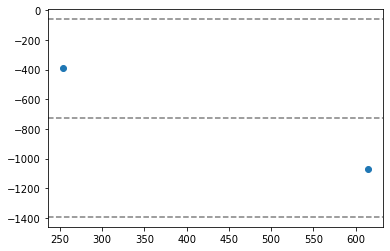

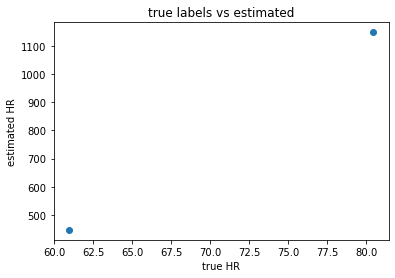

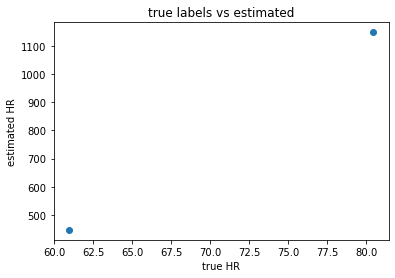

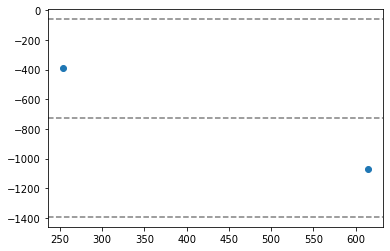

In [53]:
# -----------------------------
# Start Validation
# -----------------------------


print(f"Finished Training, Validating {len(video_files_test)} video files for {config.EPOCHS_TEST} Epochs")

eval_loss_per_epoch = []
for epoch in range(config.EPOCHS_TEST):
    # validation
    target_hr_list, predicted_hr_list, test_loss = train_val.eval_fn(model, test_loader, loss_fn)

    # truth_hr_list.append(target)
    # estimated_hr_list.append(predicted)
    metrics = compute_criteria(target_hr_list, predicted_hr_list)
    for metric in metrics.keys():
        writer.add_scalar(f"Test/{metric}", metrics[metric], epoch)

    print(f"\nFinished Test [Epoch: {epoch + 1}/{config.EPOCHS_TEST}]",
            "\nTest Loss: {:.3f} |".format(test_loss),
            "HR_MAE : {:.3f} |".format(metrics["MAE"]),
            "HR_RMSE : {:.3f} |".format(metrics["RMSE"]),)

    writer.add_scalar("Loss/test", test_loss, epoch)

    # Plots on tensorboard
    ba_plot_image = create_plot_for_tensorboard('bland_altman', target_hr_list, predicted_hr_list)
    gtvsest_plot_image = create_plot_for_tensorboard('gt_vs_est', target_hr_list, predicted_hr_list)
    writer.add_image('BA_plot', ba_plot_image, epoch)
    writer.add_image('gtvsest_plot', gtvsest_plot_image, epoch)


# print(f"Avg Validation Loss: {mean_test_loss} for {config.EPOCHS_TEST} epochs")
writer.flush()
# plot_train_test_curves(train_loss_data, test_loss_data, plot_path=config.PLOT_PATH, fold_tag=k)
# Plots on the local storage.
gt_vs_est(target_hr_list, predicted_hr_list, plot_path=config.PLOT_PATH)
bland_altman_plot(target_hr_list, predicted_hr_list, plot_path=config.PLOT_PATH)
writer.close()
print("done")

In [17]:
data = next(iter(test_loader))[0]
st_maps, target = data['st_maps'], data['target']
model.eval()
with torch.no_grad():
    pred = model(st_maps, target)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 300, 25, 3] to have 3 channels, but got 300 channels instead

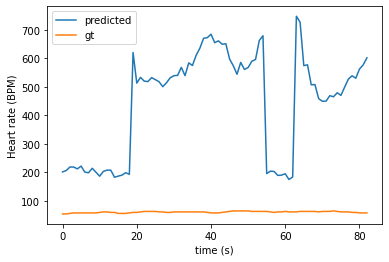

In [ ]:
fig, ax = plt.subplots()
x = range(len(target))
ax.plot(pred[0].flatten(), label='predicted')
ax.plot(target, label='gt')
ax.set_xlabel('time (s)')
ax.set_ylabel('Heart rate (BPM)')
ax.legend();